In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import plotly.express as px
from pathlib import Path
from scipy.stats import gaussian_kde
from matplotlib import cm

In [2]:
path_to_data = Path.cwd() / "resources" / "other_datasets_lesions_info.csv"
min_voxels = 50
min_slices = 2

In [3]:
df = pd.read_csv(path_to_data)

In [4]:
# Add column to identify the image
df["image"] = df.apply(
    lambda row: f"{'-'.join([row['dataset'], row['patient'], row['study'], row['filename']])}",
    axis=1
)

In [5]:
# Remove lesions smaller than 50 voxels or with 1 slice
df = df[
    (df["voxels_count"] >= min_voxels) |
    (df["slices_count"] >= min_slices)
].copy()

In [6]:
# Total annotated lesions
grouped = df.groupby('dataset').size().reset_index(name='lesions_count')
display(grouped.sort_values(by='lesions_count'))

,dataset,lesions_count
0,Adrenal-ACC-Ki67,54
10,Task06_Lung,70
4,KiPA22,72
13,Task10_Colon,130
3,HCC-TACE-Seg,145
7,NSCLC-Radiogenomics,156
2,GLIS-RT,250
11,Task07_Pancreas,283
12,Task08_HepaticVessel,532
5,KiTS23,602


In [7]:
# Total annotated volume
grouped = df.groupby('dataset')[['volume_mm3', 'volume_ml']].sum()
display(grouped)

,volume_mm3,volume_ml
dataset,,
Adrenal-ACC-Ki67,2.815078e+07,28150.777203
CT-Lymph-Nodes,4.912883e+06,4912.883119
GLIS-RT,3.259464e+07,32594.640646
HCC-TACE-Seg,4.002449e+07,40024.492483
KiPA22,2.852676e+06,2852.675798
KiTS23,6.454911e+07,64549.105090
Mediastinal-Lymph-Node-SEG,9.796613e+06,9796.613349
NSCLC-Radiogenomics,3.905487e+06,3905.486775
PET-CT,1.100855e+08,110085.477634


In [8]:
# Volumes with annotated lesions
grouped = df.groupby(['dataset'])['image'].nunique().reset_index(name='annotated_volumes')
display(grouped)

,dataset,annotated_volumes
0,Adrenal-ACC-Ki67,53
1,CT-Lymph-Nodes,1031
2,GLIS-RT,229
3,HCC-TACE-Seg,105
4,KiPA22,70
5,KiTS23,489
6,Mediastinal-Lymph-Node-SEG,513
7,NSCLC-Radiogenomics,144
8,PET-CT,501
9,Task03_Liver,118


In [9]:
# Statistics of annotated lesions (volume_ml)
grouped = df.groupby('dataset')['volume_ml'].describe()
display(grouped)

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
Adrenal-ACC-Ki67,54.0,521.310689,1123.448462,0.584412,54.587495,177.445068,549.581985,7863.760712
CT-Lymph-Nodes,1031.0,4.765163,10.698951,0.019996,1.100525,2.340375,4.763207,209.709473
GLIS-RT,250.0,130.378563,91.379041,0.464349,56.726751,121.228342,188.197556,473.378970
HCC-TACE-Seg,145.0,276.030983,569.153760,0.066742,8.989014,43.507113,245.304955,4054.628325
KiPA22,72.0,39.620497,47.833205,1.941254,10.800999,26.058104,49.480939,263.874677
KiTS23,602.0,107.224427,245.738676,0.001308,4.774009,18.324243,71.527078,2590.918263
Mediastinal-Lymph-Node-SEG,1438.0,6.812666,16.027156,0.005490,0.540306,2.189587,6.029569,224.386235
NSCLC-Radiogenomics,156.0,25.035172,53.826520,0.003815,2.555422,6.605518,22.184753,371.856445
PET-CT,7141.0,15.415975,77.274389,0.024882,0.559846,1.542687,4.615619,2144.682651


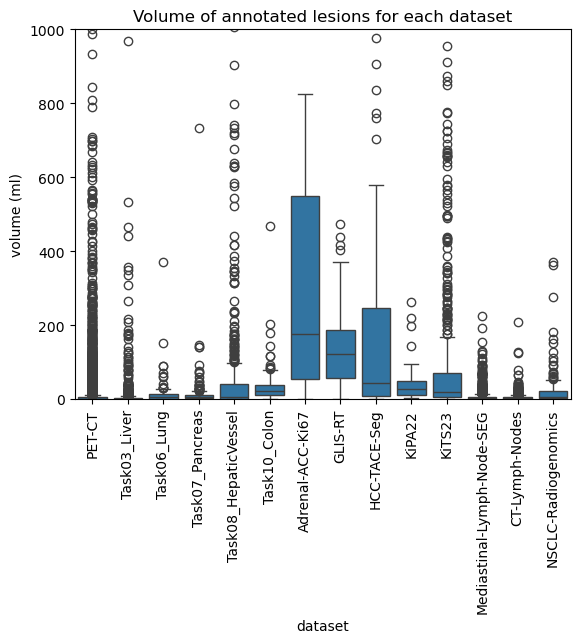

In [11]:
# Boxplots of lesion volumes
sns.boxplot(x="dataset", y="volume_ml", data=df)
plt.title("Volume of annotated lesions for each dataset")
plt.xticks(rotation=90)
plt.ylabel("volume (ml)")
plt.ylim([0, 1000])
plt.show()

In [12]:
df.columns

Index(['dataset', 'patient', 'study', 'filename', 'voxels_count',
       'slices_count', 'volume_mm3', 'volume_ml', 'label_value', 'major_axis',
       'minor_axis', 'major_axis_slice_idx', 'image'],
      dtype='object')

In [30]:
data = df[df['dataset'] == dataset]['volume_ml'].dropna()
data.min()

0.58441162109375

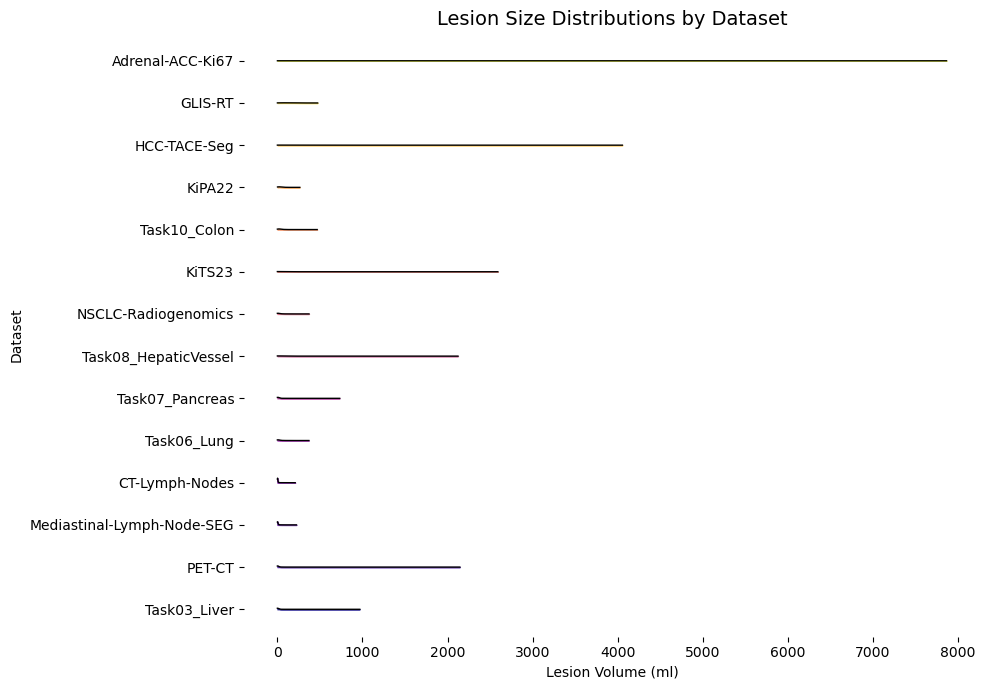

In [33]:
# Ridge plot (overlapping densities) for lesions size in ml
datasets = sorted(df['dataset'].unique())
datasets = sorted(
    datasets,
    key=lambda d: df[df['dataset'] == d]['volume_ml'].median()
)

# Set up plot
fig, ax = plt.subplots(figsize=(10, 0.5 * len(datasets)))
colors = cm.plasma(np.linspace(0, 1, len(datasets)))

#x_vals = np.linspace(df['volume_ml'].min(), df['volume_ml'].max(), 500)
#x_vals = np.linspace(0, 20, 500)

for i, (dataset, color) in enumerate(zip(datasets, colors)):
    data = df[df['dataset'] == dataset]['volume_ml'].dropna()    
    if len(data) < 2:
        continue
    x_vals = np.linspace(data.min(), data.max(), 500)
    kde = gaussian_kde(data)
    y = kde(x_vals)

    ax.fill_between(x_vals, i, i + y, color=color, alpha=0.7)
    ax.plot(x_vals, i + y, color='black', lw=1)

# Formatting
ax.set_yticks(np.arange(len(datasets)))
ax.set_yticklabels(datasets)
ax.set_xlabel("Lesion Volume (ml)")
ax.set_ylabel("Dataset")
ax.set_title("Lesion Size Distributions by Dataset", fontsize=14)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

# Analysis from final table

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [ ]:
path_to_csv = Path.cwd() / "resources" / "datasets_with_annotations_for_tumor_segmentation.csv"

In [ ]:
table_df = pd.read_csv(path_to_csv)
table_df.columns

In [ ]:
columns = [
    'Modality',
    'Anatomical region',
    'Affected organ',
    'File format',
    'Multicentric data',
    'License'
]
# Create subplot grid: 2 rows × 3 columns
fig = make_subplots(
    rows=2, cols=3,
    specs=[[{'type':'domain'}]*3]*2,  # 'domain' is needed for pie charts
    subplot_titles=columns
)
row, col = 1, 1
for i, column in enumerate(columns):
    counts = table_df[column].value_counts().reset_index(name='counts')
    fig.add_trace(
        go.Pie(
            labels=counts[column],
            values=counts['counts'],
            textinfo='label+value',
            textposition='inside'
        ),
        row=row,
        col=col
    )
    col += 1
    if col > 3:
        col = 1
        row += 1

fig.update_layout(
    height=700,
    width=800,
    title_text="Distribution per Variable",
    showlegend=False
)
fig.show()

In [ ]:
# Reporting of per-patient variables (diagnosis, age, sex, ethnicity/race)

In [ ]:
# Distribution of Patients, Annotated images, Annotated lesions

In [ ]:
# Distribution of Lesions types (primary, metastases, lymph node)

In [ ]:
# Distribution of Annotators count 